# Evaluated MobileNetV2's performance after training.

- Author: Ankita Jaswal

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.models import Sequential, model_from_json
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Activation
from keras.preprocessing.image import ImageDataGenerator
from sklearn import model_selection
from math import ceil
import cv2
import tensorflow as tf

In [ ]:
print(tf.__version__)

2.14.0


In [ ]:
img_array=cv2.imread("/content/drive/Shareddrives/CMPE 258 - Deep Learning Project/Datasets/train_data_processed/surprise/35875.jpg")

In [ ]:
img_array.shape

(48, 48, 3)

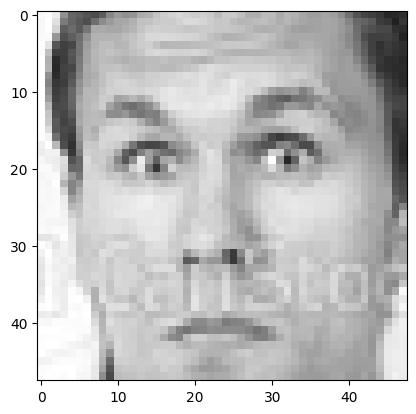

In [ ]:
plt.imshow(img_array)

In [ ]:
datadirectory="/content/drive/Shareddrives/CMPE 258 - Deep Learning Project/Datasets/train_data_processed"

In [ ]:
classes=["surprise","sad","neutral","happy","fear","disgust","angry"]

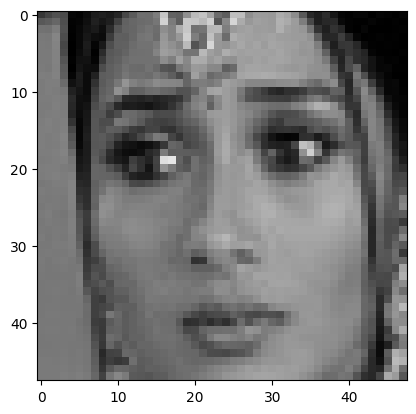

In [ ]:
for category in classes:
  path=os.path.join(datadirectory,category)
  for img in os.listdir(path):
    img_array=cv2.imread(os.path.join(path,img))
    plt.imshow(cv2.cvtColor(img_array,cv2.COLOR_BGR2RGB))
    plt.show()
    break
  break

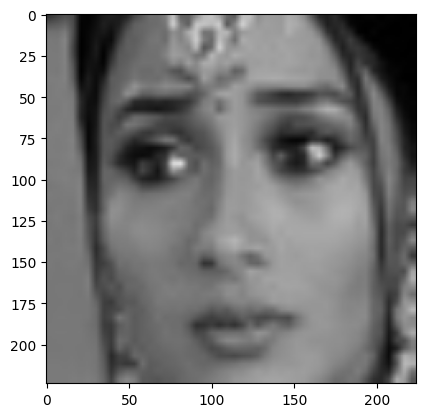

In [ ]:
img_size=224
new_array=cv2.resize(img_array,(img_size,img_size))
plt.imshow(cv2.cvtColor(new_array,cv2.COLOR_BGR2RGB))

convert images to array

In [ ]:
from logging import exception
training_data=[]
def create_training_data():
  for category in classes:
    path=os.path.join(datadirectory, category)
    class_num=classes.index(category)
    for img in os.listdir(path):
      try:
        img_array=cv2.imread(os.path.join(path,img))
        new_array=cv2.resize(img_array,(img_size,img_size))
        training_data.append([new_array,class_num])
      except exception as e:
        pass
  return training_data

In [ ]:
train_data = create_training_data()

In [ ]:
import joblib

# save train data for mobilenet
save_path = '/content/drive/Shareddrives/CMPE 258 - Deep Learning Project/MobileNet/train_data.joblib'
joblib.dump(train_data, save_path)

['/content/drive/Shareddrives/CMPE 258 - Deep Learning Project/MobileNet/train_data.joblib']

In [ ]:
import joblib

datadir = '/content/drive/Shareddrives/CMPE 258 - Deep Learning Project/MobileNet/train_data.joblib'

In [ ]:
data = joblib.load(datadir)

In [ ]:
print(len(data))

31189


In [ ]:
import random
random.shuffle(data)

In [ ]:
x=[]
y=[]
img_size=224
for features,label in data:
  x.append(features)
  y.append(label)
# Convert list x to numpy array
x=np.array(x).reshape(-1,img_size,img_size,3)

In [ ]:
x.shape

(31189, 224, 224, 3)

In [ ]:
# Convert list y to numpy array
y=np.array(y)

In [ ]:
y.shape

(31189,)

### Train-Test Split

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets (80% training, 20% validation)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, stratify=y)



In [ ]:
print("Training Data:")
print("Features (x_train):", x_train.shape)
print("Labels (y_train):", y_train.shape)

print("\nValidation Data:")
print("Features (x_val):", x_val.shape)
print("Labels (y_val):", y_val.shape)


Training Data:
Features (x_train): (24951, 224, 224, 3)
Labels (y_train): (24951,)

Validation Data:
Features (x_val): (6238, 224, 224, 3)
Labels (y_val): (6238,)


# Model training-transfer learning using MobileNetV2 and training for emotion recognition task

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
model=tf.keras.applications.MobileNetV2()

14536120/14536120 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

In [ ]:
base_input=model.layers[0].input
base_output=model.layers[-2].output

In [ ]:
base_output

<KerasTensor: shape=(None, 1280) dtype=float32 (created by layer 'global_average_pooling2d')>

In [ ]:
final_output=layers.Dense(128)(base_output)
final_output=layers.Activation('relu')(final_output)
final_output=layers.Dense(64)(final_output)
final_output=layers.Activation('relu')(final_output)
final_output=layers.Dense(7,activation='softmax')(final_output)

In [ ]:
final_output

<KerasTensor: shape=(None, 7) dtype=float32 (created by layer 'dense_2')>

In [ ]:
new_model=keras.Model(inputs=base_input,outputs=final_output)

In [ ]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

### Learning Rate Scheduler and Early Stopping for training

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Set up EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,         # Number of epochs with no improvement after which training will be stopped
    verbose=1,
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
)


### for scheduler, starts decaying exponentionally after 10 epochs

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# Set up LearningRateScheduler
lr_scheduler = LearningRateScheduler(scheduler, verbose=1)


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Set up ModelCheckpoint
checkpoint = ModelCheckpoint(
    '/content/drive/Shareddrives/CMPE 258 - Deep Learning Project/model_data/mobilenetv2_checkpoint.h5',
    monitor='val_loss',            # Monitor the validation loss
    verbose=1,                     # Logging level
    save_best_only=True,           # Save only the best model
    save_weights_only=False,       # If True, only weights are saved
    mode='auto',                   # Auto mode means the direction is inferred
    save_freq='epoch'              # Save after each epoch
)


In [ ]:
EPOCHS = 20

# Compile model
new_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model with callbacks
history = new_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=EPOCHS,
    batch_size=32,
    callbacks=[checkpoint, early_stopping, lr_scheduler]
)



Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/20
780/780 [==============================] - ETA: 0s - loss: 1.2892 - accuracy: 0.5166
Epoch 1: val_loss improved from inf to 2.78078, saving model to /content/drive/Shareddrives/CMPE 258 - Deep Learning Project/model_data/mobilenetv2_checkpoint.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


780/780 [==============================] - 76s 59ms/step - loss: 1.2892 - accuracy: 0.5166 - val_loss: 2.7808 - val_accuracy: 0.4203 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/20
779/780 [============================>.] - ETA: 0s - loss: 1.0824 - accuracy: 0.5909
Epoch 2: val_loss did not improve from 2.78078
780/780 [==============================] - 44s 56ms/step - loss: 1.0825 - accuracy: 0.5909 - val_loss: 4.8079 - val_accuracy: 0.2159 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/20
779/780 [============================>.] - ETA: 0s - loss: 0.9935 - accuracy: 0.6268
Epoch 3: val_loss did not improve from 2.78078
780/780 [==============================] - 40s 51ms/step - loss: 0.9936 - accuracy: 0.6268 - val_loss: 6.0878 - val_accuracy: 0.1811 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/20
780/780 [================

In [ ]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points


[0.5165724754333496, 0.5909181833267212, 0.6267884969711304, 0.6545228362083435, 0.6721975207328796, 0.702376663684845, 0.7275860905647278, 0.7600497007369995, 0.7945172786712646, 0.831750214099884]
[0.4203270375728607, 0.21593458950519562, 0.18114779889583588, 0.4057390093803406, 0.3081115782260895, 0.5394357442855835, 0.5349470973014832, 0.5001603364944458, 0.6059634685516357, 0.6173452734947205]
[1.2891507148742676, 1.082470417022705, 0.9935959577560425, 0.932319700717926, 0.8830210566520691, 0.8084486126899719, 0.7289093732833862, 0.6533641219139099, 0.5656903386116028, 0.4732896089553833]
[2.7807798385620117, 4.8078813552856445, 6.0878119468688965, 2.3799221515655518, 3.3508784770965576, 1.4430373907089233, 1.3337763547897339, 1.8162959814071655, 1.367175579071045, 1.3651963472366333]


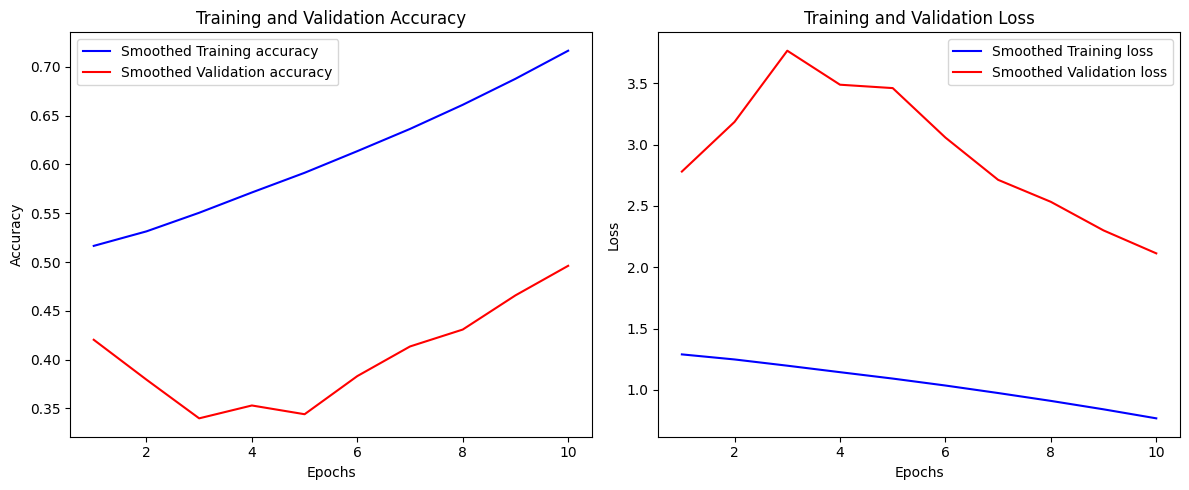

In [ ]:
import matplotlib.pyplot as plt

def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

print(acc)
print(val_acc)
print(loss)
print(val_loss)

smooth_acc = smooth_curve(acc)
smooth_val_acc = smooth_curve(val_acc)
smooth_loss = smooth_curve(loss)
smooth_val_loss = smooth_curve(val_loss)

epochs = range(1, len(acc) + 1)

# Plot training & validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, smooth_acc, 'b', label='Smoothed Training accuracy')
plt.plot(epochs, smooth_val_acc, 'r', label='Smoothed Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, smooth_loss, 'b', label='Smoothed Training loss')
plt.plot(epochs, smooth_val_loss, 'r', label='Smoothed Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



Can't attempt to cross validate best hyperparams, not enough memory for GPU, limited to 16 GBs and it's capped out.

In [ ]:
new_model.save("/content/drive/Shareddrives/CMPE 258 - Deep Learning Project/model_data/mobilenet_12-1-2023.h5")

# Evaluate Performance

In [ ]:
new_model=tf.keras.models.load_model("/content/drive/Shareddrives/CMPE 258 - Deep Learning Project/model_data/mobilenet_newmodel.h5")

In [ ]:
!pip install mtcnn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 15.8 MB/s eta 0:00:00


In [ ]:
from mtcnn import MTCNN
import cv2

# Initialize MTCNN
detector = MTCNN()

# Load your image
frame=cv2.imread("/content/drive/Shareddrives/CMPE 258 - Deep Learning Project/Datasets/train_data/surprise/35875.jpg")
image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# Detect faces
faces = detector.detect_faces(image_rgb)


In [ ]:
face_images = []

for face in faces:
    x, y, width, height = face['box']
    face_image = image_rgb[y:y+height, x:x+width]

    # Resize face image to the expected size by the model
    face_image = cv2.resize(face_image, (224, 224))

    face_images.append(face_image)

face_images = np.array(face_images)


In [ ]:
predictions = new_model.predict(face_images)

# Convert predictions to labels
predicted_labels = [classes[np.argmax(pred)] for pred in predictions]


183/183 [==============================] - 3s 14ms/step


# Evaluate using data from dataset

In [ ]:
import os
import cv2
import numpy as np
from mtcnn import MTCNN

data_path = "/content/drive/Shareddrives/CMPE 258 - Deep Learning Project/Datasets/train_data"
INPUT_SIZE = (224, 224)
classes = ["surprise", "sad", "neutral", "happy", "fear", "disgust", "angry"]
detector = MTCNN()

face_images = []
actual_labels = []

for emotion_folder in os.listdir(data_path):
    emotion_path = os.path.join(data_path, emotion_folder)
    if os.path.isdir(emotion_path):
        counter = 0  # Initialize a counter for each folder
        for img_file in os.listdir(emotion_path):
            if counter < 5:  # Process only 5 images per folder
                img_path = os.path.join(emotion_path, img_file)
                image = cv2.imread(img_path)
                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                faces = detector.detect_faces(image_rgb)

                for face in faces:
                    x, y, width, height = face['box']
                    face_image = image_rgb[y:y+height, x:x+width]
                    resized_face = cv2.resize(face_image, INPUT_SIZE)
                    face_images.append(resized_face)
                    actual_labels.append(emotion_folder)  # Folder name as the actual label

                counter += 1  # Increment the counter
            else:
                break  # Move to the next folder

# Convert lists to numpy arrays
face_images = np.array(face_images)


1/1 [==============================] - 0s 18ms/step


In [ ]:
predictions = new_model.predict(face_images)

# Convert predictions to labels
predicted_labels = [classes[np.argmax(pred)] for pred in predictions]


1/1 [==============================] - 0s 240ms/step


Accuracy: 56.41%
              precision    recall  f1-score   support

    surprise       0.64      0.79      0.71       683
         sad       0.38      0.38      0.38       940
     neutral       0.47      0.59      0.52      1081
       happy       0.79      0.85      0.82      1484
        fear       0.54      0.13      0.20       803
     disgust       0.37      0.37      0.37        84
       angry       0.44      0.48      0.46       775

    accuracy                           0.56      5850
   macro avg       0.52      0.51      0.49      5850
weighted avg       0.56      0.56      0.54      5850



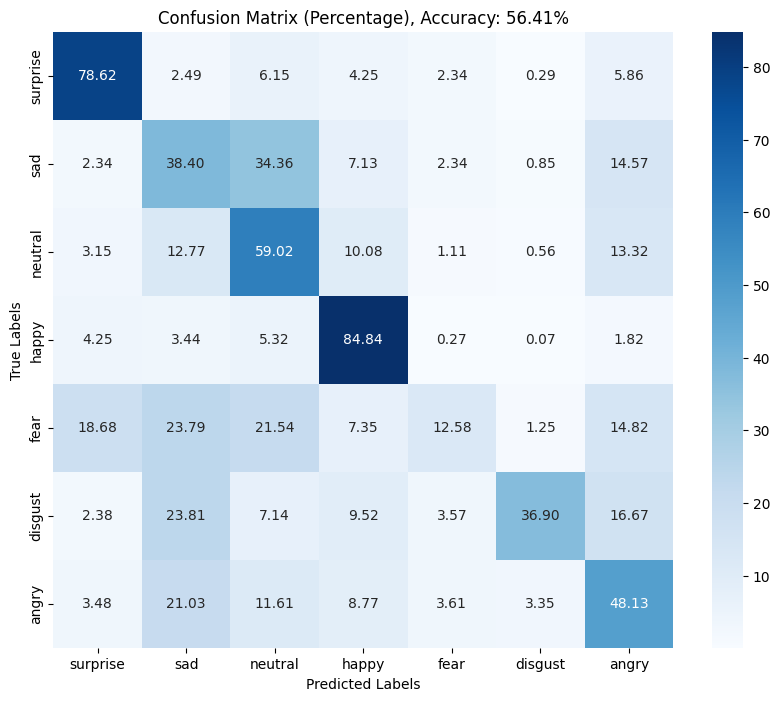

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Convert actual string labels to indices
actual_indices = [classes.index(label) for label in actual_labels]

# Convert predicted string labels to indices
predicted_indices = [classes.index(label) for label in predicted_labels]

# Calculate accuracy
accuracy = accuracy_score(actual_indices, predicted_indices)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Generate confusion matrix
cm = confusion_matrix(actual_indices, predicted_indices)

# Normalize the confusion matrix to show percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_percentage *= 100  # Convert to percentage

# Generate and print classification report
report = classification_report(actual_indices, predicted_indices, target_names=classes)
print(report)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title(f'Confusion Matrix (Percentage), Accuracy: {accuracy * 100:.2f}%')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


Accuracy: 56.00%
              precision    recall  f1-score   support

    surprise       1.00      1.00      1.00         2
         sad       0.00      0.00      0.00         3
     neutral       0.60      0.75      0.67         4
       happy       0.75      1.00      0.86         3
        fear       0.33      0.33      0.33         3
     disgust       1.00      0.20      0.33         5
       angry       0.80      0.80      0.80         5

    accuracy                           0.56        25
   macro avg       0.64      0.58      0.57        25
weighted avg       0.67      0.56      0.56        25



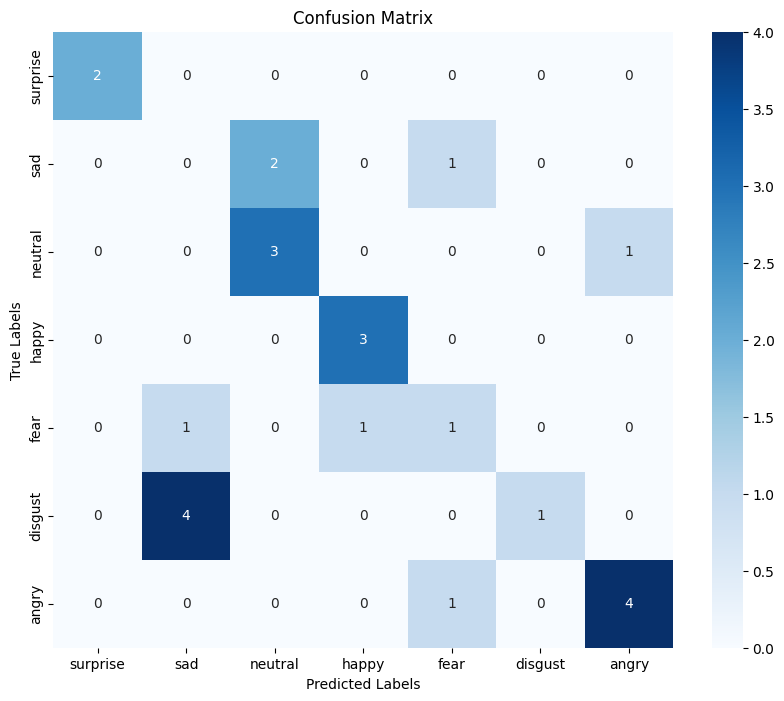

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Convert actual string labels to indices
actual_indices = [classes.index(label) for label in actual_labels]

# Convert predicted string labels to indices
predicted_indices = [classes.index(label) for label in predicted_labels]

# Calculate accuracy
accuracy = accuracy_score(actual_indices, predicted_indices)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Generate confusion matrix
cm = confusion_matrix(actual_indices, predicted_indices)

# Generate and print classification report
report = classification_report(actual_indices, predicted_indices, target_names=classes)
print(report)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


# Trying A-MobileNet Approach
Source: https://www.sciencedirect.com/science/article/pii/S1110016821006682#b0125

The paper uses CBAM in the depth-wise separation convolution (DSC) block instead of ReLU which leads to information loss.

CBAM implementation is provided by a different source:
* https://github.com/luuuyi/CBAM.PyTorch/tree/master
* https://github.com/AndrzejMiskow/FER-with-Attention-and-Objective-Activation-Functions/tree/main

They claim this attention mechanism helps retain more information especially localizing the facial landmarks like the eye region and mouth region for improved performance, in terms of accuracy.

In [ ]:
def CBAM_block(input_layer, filter_num, reduction_ratio=32, kernel_size=7, name=None):
	"""CBAM: Convolutional Block Attention Module Block
    Args:
      input_layer: input tensor
      filter_num: integer, number of neurons in the hidden layers
      reduction_ratio: integer, default 32,reduction ratio for the number of neurons in the hidden layers
      kernel_size: integer, default 7, kernel size of the spatial convolution excitation convolution
      name: string, block label
    Returns:
      Output A tensor for the CBAM attention block
    """
	axis = -1

	# CHANNEL ATTENTION
	avg_pool = layers.GlobalAveragePooling2D(name=name + "_Chanel_AveragePooling")(input_layer)
	max_pool = layers.GlobalMaxPool2D(name=name + "_Chanel_MaxPooling")(input_layer)

	# Shared MLP
	dense1 = layers.Dense(filter_num // reduction_ratio, activation='relu', name=name + "_Chanel_FC_1")
	dense2 = layers.Dense(filter_num, name=name + "_Chanel_FC_2")

	avg_out = dense2(dense1(avg_pool))
	max_out = dense2(dense1(max_pool))

	channel = layers.add([avg_out, max_out])
	channel = layers.Activation('sigmoid', name=name + "_Chanel_Sigmoid")(channel)
	channel = layers.Reshape((1, 1, filter_num), name=name + "_Chanel_Reshape")(channel)

	channel_output = layers.multiply([input_layer, channel])

	# SPATIAL ATTENTION
	avg_pool2 = tf.reduce_mean(input_layer, axis=axis, keepdims=True)
	max_pool2 = tf.reduce_max(input_layer, axis=axis, keepdims=True)

	spatial = layers.concatenate([avg_pool2, max_pool2], axis=axis)

	# K = 7 achieves the highest accuracy
	spatial = layers.Conv2D(1, kernel_size=kernel_size, padding='same', name=name + "_Spatial_Conv2D")(spatial)
	spatial_out = layers.Activation('sigmoid', name=name + "_Spatial_Sigmoid")(spatial)

	CBAM_out = layers.multiply([channel_output, spatial_out])

	return CBAM_out

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Load MobileNetV2 without the top layer (include_top=False)
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False)

# Apply CBAM after the last convolutional layer of MobileNetV2
last_conv_layer = base_model.output
cbam_output = CBAM_block(last_conv_layer, filter_num=last_conv_layer.shape[-1], name="cbam")

# Add global pooling followed by custom dense layers
pooling_output = layers.GlobalAveragePooling2D()(cbam_output)
final_output = layers.Dense(128, activation='relu')(pooling_output)
final_output = layers.Dense(64, activation='relu')(final_output)
final_output = layers.Dense(7, activation='softmax')(final_output)

# Create new model
new_model_cbam = models.Model(inputs=base_model.input, outputs=final_output)

new_model_cbam.summary()


9406464/9406464 [==============================] - 1s 0us/step
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_8[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Set up EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,         # Number of epochs with no improvement after which training will be stopped
    verbose=1,
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
)


In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# Set up LearningRateScheduler
lr_scheduler = LearningRateScheduler(scheduler, verbose=1)

In [ ]:
EPOCHS = 20

# Compile model
new_model_cbam.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

# Train the model with callbacks
history = new_model_cbam.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=EPOCHS,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler]
)



Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/20
780/780 [==============================] - 67s 59ms/step - loss: 1.1885 - accuracy: 0.5539 - val_loss: 3.8490 - val_accuracy: 0.2645 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/20
780/780 [==============================] - 44s 56ms/step - loss: 1.0339 - accuracy: 0.6176 - val_loss: 3.3569 - val_accuracy: 0.3282 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/20
780/780 [==============================] - 44s 57ms/step - loss: 0.9551 - accuracy: 0.6451 - val_loss: 2.0256 - val_accuracy: 0.4881 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/20
780/780 [==============================] - 44s 56ms/step - loss: 0.8916 - accuracy: 0.6679 - val_loss: 2.4590 - val_accuracy: 0.3240 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rat

[0.5539256930351257, 0.6175704598426819, 0.6451044082641602, 0.6679491996765137, 0.6889503598213196, 0.7210131883621216, 0.7502705454826355, 0.7832151055335999, 0.8197266459465027, 0.852510929107666, 0.8801250457763672, 0.9121878743171692]
[0.26450785994529724, 0.32815003395080566, 0.48813721537590027, 0.3239820599555969, 0.4719461500644684, 0.46120551228523254, 0.5060917139053345, 0.5224431157112122, 0.6059634685516357, 0.5865662097930908, 0.621513307094574, 0.6333760619163513]
[1.1884998083114624, 1.0339430570602417, 0.9550529718399048, 0.8915824890136719, 0.843259871006012, 0.7578467726707458, 0.679293692111969, 0.5984857082366943, 0.5032349228858948, 0.4105028212070465, 0.3308746814727783, 0.24977776408195496]
[3.8489694595336914, 3.356870174407959, 2.0256247520446777, 2.4589591026306152, 1.7227072715759277, 1.7983274459838867, 1.5859673023223877, 1.423181414604187, 1.2299968004226685, 1.4528844356536865, 1.2884113788604736, 1.342600703239441]


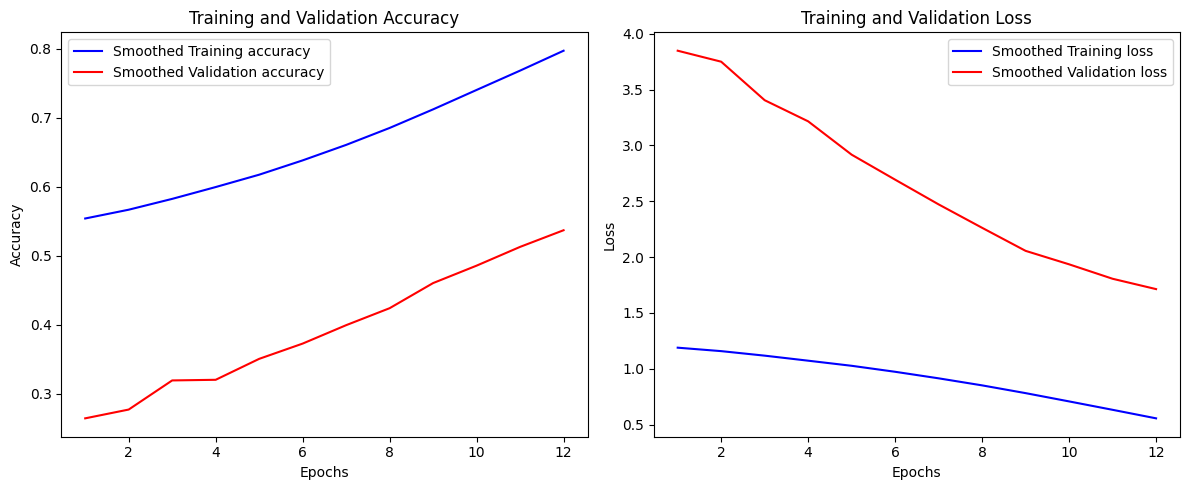

In [ ]:
import matplotlib.pyplot as plt

def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

print(acc)
print(val_acc)
print(loss)
print(val_loss)

smooth_acc = smooth_curve(acc)
smooth_val_acc = smooth_curve(val_acc)
smooth_loss = smooth_curve(loss)
smooth_val_loss = smooth_curve(val_loss)

epochs = range(1, len(acc) + 1)

# Plot training & validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, smooth_acc, 'b', label='Smoothed Training accuracy')
plt.plot(epochs, smooth_val_acc, 'r', label='Smoothed Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, smooth_loss, 'b', label='Smoothed Training loss')
plt.plot(epochs, smooth_val_loss, 'r', label='Smoothed Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



In [ ]:
new_model_cbam.save("/content/drive/Shareddrives/CMPE 258 - Deep Learning Project/model_data/mobilenet_cbam_best.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#Evaluate CBAM

In [ ]:
load_model_cbam=tf.keras.models.load_model("/content/drive/Shareddrives/CMPE 258 - Deep Learning Project/model_data/mobilenet_cbam_best.h5")

In [ ]:
import os
import cv2
import numpy as np
from mtcnn import MTCNN

data_path = "/content/drive/Shareddrives/CMPE 258 - Deep Learning Project/Datasets/test"
INPUT_SIZE = (224, 224)
classes = ["surprise", "sad", "neutral", "happy", "fear", "disgust", "angry"]
detector = MTCNN()

face_images = []
actual_labels = []

for emotion_folder in os.listdir(data_path):
    emotion_path = os.path.join(data_path, emotion_folder)
    if os.path.isdir(emotion_path):
       # counter = 0  # Initialize a counter for each folder
        for img_file in os.listdir(emotion_path):
           # if counter < 5:  # Process only 5 images per folder
                img_path = os.path.join(emotion_path, img_file)
                image = cv2.imread(img_path)
                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                faces = detector.detect_faces(image_rgb)

                for face in faces:
                    x, y, width, height = face['box']
                    face_image = image_rgb[y:y+height, x:x+width]
                    resized_face = cv2.resize(face_image, INPUT_SIZE)
                    face_images.append(resized_face)
                    actual_labels.append(emotion_folder)  # Folder name as the actual label

                #counter += 1  # Increment the counter
          #  else:
               # break  # Move to the next folder

# Convert lists to numpy arrays
face_images = np.array(face_images)


1/1 [==============================] - 0s 98ms/step


1/1 [==============================] - 0s 17ms/step


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 21ms/step


In [ ]:
predictions = load_model_cbam.predict(face_images)

# Convert predictions to labels
predicted_labels = [classes[np.argmax(pred)] for pred in predictions]



183/183 [==============================] - 3s 16ms/step


Accuracy: 60.70%
              precision    recall  f1-score   support

    surprise       0.81      0.66      0.72       683
         sad       0.67      0.25      0.36       940
     neutral       0.56      0.59      0.57      1081
       happy       0.73      0.94      0.82      1484
        fear       0.42      0.45      0.44       803
     disgust       0.59      0.36      0.44        84
       angry       0.45      0.57      0.50       775

    accuracy                           0.61      5850
   macro avg       0.60      0.55      0.55      5850
weighted avg       0.62      0.61      0.59      5850



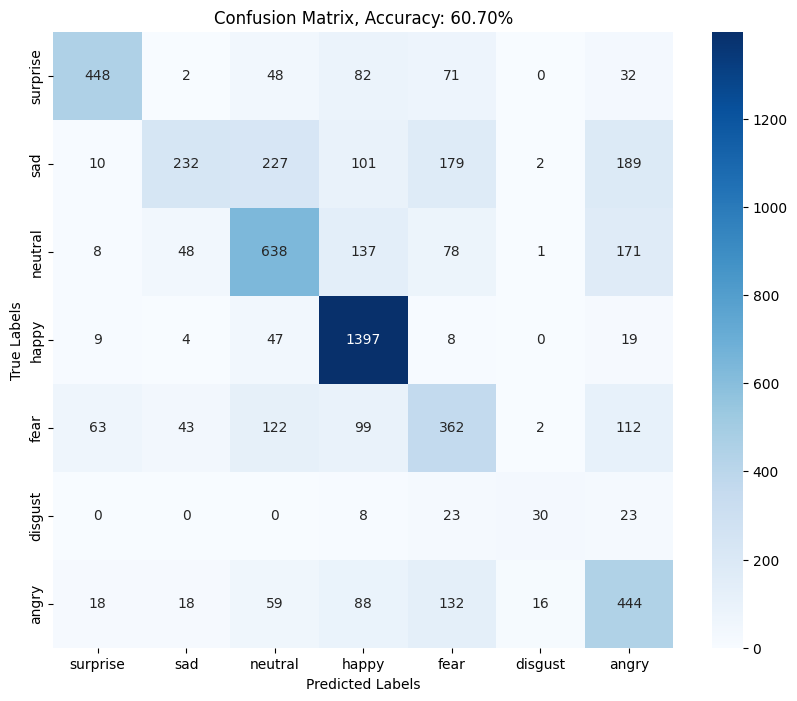

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Convert actual string labels to indices
actual_indices = [classes.index(label) for label in actual_labels]

# Convert predicted string labels to indices
predicted_indices = [classes.index(label) for label in predicted_labels]

# Calculate accuracy
accuracy = accuracy_score(actual_indices, predicted_indices)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Generate confusion matrix
cm = confusion_matrix(actual_indices, predicted_indices)

# Generate and print classification report
report = classification_report(actual_indices, predicted_indices, target_names=classes)
print(report)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title(f'Confusion Matrix, Accuracy: {accuracy * 100:.2f}%')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


Accuracy: 60.70%
              precision    recall  f1-score   support

    surprise       0.81      0.66      0.72       683
         sad       0.67      0.25      0.36       940
     neutral       0.56      0.59      0.57      1081
       happy       0.73      0.94      0.82      1484
        fear       0.42      0.45      0.44       803
     disgust       0.59      0.36      0.44        84
       angry       0.45      0.57      0.50       775

    accuracy                           0.61      5850
   macro avg       0.60      0.55      0.55      5850
weighted avg       0.62      0.61      0.59      5850



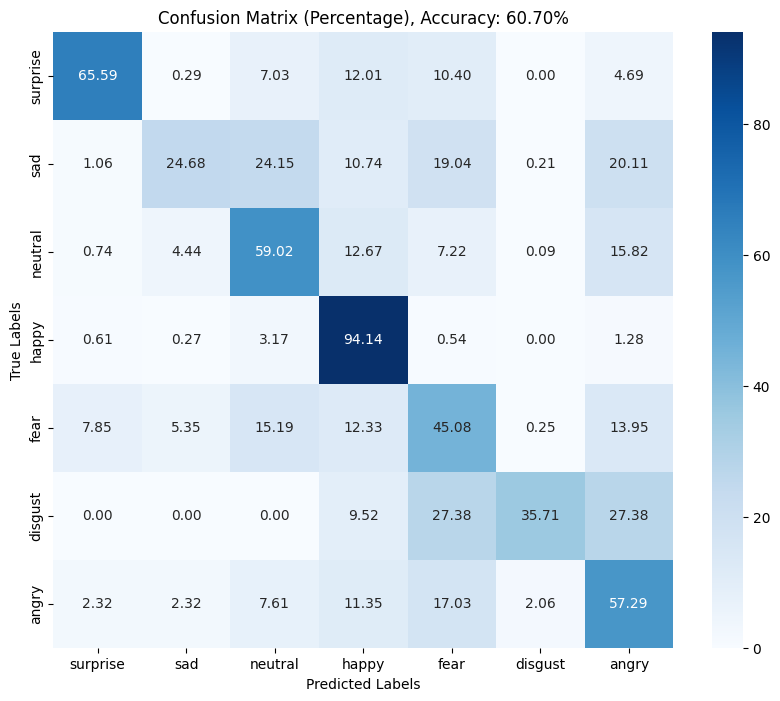

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Convert actual string labels to indices
actual_indices = [classes.index(label) for label in actual_labels]

# Convert predicted string labels to indices
predicted_indices = [classes.index(label) for label in predicted_labels]

# Calculate accuracy
accuracy = accuracy_score(actual_indices, predicted_indices)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Generate confusion matrix
cm = confusion_matrix(actual_indices, predicted_indices)

# Normalize the confusion matrix to show percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_percentage *= 100  # Convert to percentage

# Generate and print classification report
report = classification_report(actual_indices, predicted_indices, target_names=classes)
print(report)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title(f'Confusion Matrix (Percentage), Accuracy: {accuracy * 100:.2f}%')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


# Let's try custom as described in A-MobileNet

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_custom_model():
    input_layer = layers.Input(shape=(224, 224, 3))

    # Conv/s2 - 3x3x3x32
    x = layers.Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu')(input_layer)

    # Conv dw/s1 - 3x3x32 dw
    x = layers.DepthwiseConv2D(kernel_size=3, strides=1, padding='same', activation='relu')(x)
    x = layers.Conv2D(32, kernel_size=1, strides=1, padding='same', activation='relu')(x)

    # Conv/s1 - 1x1x32x64
    x = layers.Conv2D(64, kernel_size=1, strides=1, padding='same', activation='relu')(x)

    # Conv dw/s2 - 3x3x64 dw
    x = layers.DepthwiseConv2D(kernel_size=3, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2D(64, kernel_size=1, strides=1, padding='same', activation='relu')(x)

    # Conv/s1 - 1x1x64x128
    x = layers.Conv2D(128, kernel_size=1, strides=1, padding='same', activation='relu')(x)

    # Conv dw/s1 - 3x3x128 dw
    x = layers.DepthwiseConv2D(kernel_size=3, strides=1, padding='same', activation='relu')(x)
    x = layers.Conv2D(128, kernel_size=1, strides=1, padding='same', activation='relu')(x)

    # Conv/s1 - 1x1x128x128
    x = layers.Conv2D(128, kernel_size=1, strides=1, padding='same', activation='relu')(x)

    # Conv dw/s2 - 3x3x128 dw
    x = layers.DepthwiseConv2D(kernel_size=3, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2D(128, kernel_size=1, strides=1, padding='same', activation='relu')(x)

    # Conv/s1 - 1x1x128x256
    x = layers.Conv2D(256, kernel_size=1, strides=1, padding='same', activation='relu')(x)

    # CBAM block
    x = CBAM_block(x, filter_num=x.shape[-1], name="cbam1")

    # Conv dw/s1 - 3x3x256 dw
    x = layers.DepthwiseConv2D(kernel_size=3, strides=1, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, kernel_size=1, strides=1, padding='same', activation='relu')(x)

    # Conv/s1 - 1x1x256x256
    x = layers.Conv2D(256, kernel_size=1, strides=1, padding='same', activation='relu')(x)

    # Conv dw/s2 - 3x3x256 dw
    x = layers.DepthwiseConv2D(kernel_size=3, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, kernel_size=1, strides=1, padding='same', activation='relu')(x)

    # Conv/s1 - 1x1x256x512
    x = layers.Conv2D(512, kernel_size=1, strides=1, padding='same', activation='relu')(x)

    # CBAM block
    x = CBAM_block(x, filter_num=x.shape[-1], name="cbam2")

    # Conv dw/s1 - 3x3x512 dw
    x = layers.DepthwiseConv2D(kernel_size=3, strides=1, padding='same', activation='relu')(x)
    x = layers.Conv2D(512, kernel_size=1, strides=1, padding='same', activation='relu')(x)

    # Conv/s1 - 1x1x512x512
    x = layers.Conv2D(512, kernel_size=1, strides=1, padding='same', activation='relu')(x)

        # Conv dw/s1 - 3x3x512 dw
    x = layers.DepthwiseConv2D(kernel_size=3, strides=1, padding='same', activation='relu')(x)
    x = layers.Conv2D(512, kernel_size=1, strides=1, padding='same', activation='relu')(x)

    # Conv/s1 - 1x1x512x512
    x = layers.Conv2D(512, kernel_size=1, strides=1, padding='same', activation='relu')(x)

        # Conv dw/s1 - 3x3x512 dw
    x = layers.DepthwiseConv2D(kernel_size=3, strides=1, padding='same', activation='relu')(x)
    x = layers.Conv2D(512, kernel_size=1, strides=1, padding='same', activation='relu')(x)

    # Conv/s1 - 1x1x512x512
    x = layers.Conv2D(512, kernel_size=1, strides=1, padding='same', activation='relu')(x)

        # Conv dw/s1 - 3x3x512 dw
    x = layers.DepthwiseConv2D(kernel_size=3, strides=1, padding='same', activation='relu')(x)
    x = layers.Conv2D(512, kernel_size=1, strides=1, padding='same', activation='relu')(x)

    # Conv/s1 - 1x1x512x512
    x = layers.Conv2D(512, kernel_size=1, strides=1, padding='same', activation='relu')(x)

        # Conv dw/s1 - 3x3x512 dw
    x = layers.DepthwiseConv2D(kernel_size=3, strides=1, padding='same', activation='relu')(x)
    x = layers.Conv2D(512, kernel_size=1, strides=1, padding='same', activation='relu')(x)

    # Conv/s1 - 1x1x512x512
    x = layers.Conv2D(512, kernel_size=1, strides=1, padding='same', activation='relu')(x)

    # CBAM block
    x = CBAM_block(x, filter_num=x.shape[-1], name="cbam3")

    # Conv dw/s2 - 3x3x512 dw
    x = layers.DepthwiseConv2D(kernel_size=3, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2D(512, kernel_size=1, strides=1, padding='same', activation='relu')(x)

    # Conv/s1 - 1x1x512x1024
    x = layers.Conv2D(1024, kernel_size=1, strides=1, padding='same', activation='relu')(x)

    # Conv dw/s1 - 3x3x1024 dw
    x = layers.DepthwiseConv2D(kernel_size=3, strides=1, padding='same', activation='relu')(x)
    x = layers.Conv2D(1024, kernel_size=1, strides=1, padding='same', activation='relu')(x)

    # Conv/s1 - 1x1x1024x1024
    x = layers.Conv2D(1024, kernel_size=1, strides=1, padding='same', activation='relu')(x)

    # CBAM block
    x = CBAM_block(x, filter_num=x.shape[-1], name="cbam4")

    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Fully Connected Layers
    x = layers.Dense(1024, activation='relu')(x)
    output_layer = layers.Dense(7, activation='softmax')(x)  # Assuming 7 classes

    model = models.Model(inputs=input_layer, outputs=output_layer)
    return model

# Build and compile the model
custom_model = build_custom_model()
custom_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
custom_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 32)         896       ['input_1[0][0]']             
                                                                                                  
 depthwise_conv2d (Depthwis  (None, 112, 112, 32)         320       ['conv2d[0][0]']              
 eConv2D)                                                                                         
                                                                                                  
 conv2d_1 (Conv2D)           (None, 112, 112, 32)         1056      ['depthwise_conv2d[0][0]']

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Set up EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,         # Number of epochs with no improvement after which training will be stopped
    verbose=1,
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
)

from tensorflow.keras.callbacks import LearningRateScheduler

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# Set up LearningRateScheduler
lr_scheduler = LearningRateScheduler(scheduler, verbose=1)

In [ ]:
EPOCHS = 20

# Train the model with callbacks
history = custom_model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=32
)



Epoch 1/20
780/780 [==============================] - 46s 59ms/step - loss: 1.8259 - accuracy: 0.2496 - val_loss: 1.8270 - val_accuracy: 0.2498
Epoch 2/20
780/780 [==============================] - 43s 56ms/step - loss: 1.8257 - accuracy: 0.2496 - val_loss: 1.8248 - val_accuracy: 0.2498
Epoch 3/20
780/780 [==============================] - 44s 56ms/step - loss: 1.8253 - accuracy: 0.2496 - val_loss: 1.8278 - val_accuracy: 0.2498
Epoch 4/20
780/780 [==============================] - 43s 56ms/step - loss: 1.8254 - accuracy: 0.2496 - val_loss: 1.8251 - val_accuracy: 0.2498
Epoch 5/20
780/780 [==============================] - 43s 56ms/step - loss: 1.8252 - accuracy: 0.2496 - val_loss: 1.8252 - val_accuracy: 0.2498
Epoch 6/20
780/780 [==============================] - 44s 56ms/step - loss: 1.8256 - accuracy: 0.2496 - val_loss: 1.8245 - val_accuracy: 0.2498
Epoch 7/20
780/780 [==============================] - 44s 56ms/step - loss: 1.8252 - accuracy: 0.2496 - val_loss: 1.8259 - val_accuracy:

[0.249649316072464, 0.249649316072464, 0.249649316072464, 0.249649316072464, 0.249649316072464, 0.249649316072464, 0.249649316072464, 0.249649316072464, 0.249649316072464, 0.249649316072464, 0.249649316072464, 0.249649316072464, 0.249649316072464, 0.249649316072464, 0.249649316072464, 0.249649316072464, 0.249649316072464, 0.249649316072464, 0.249649316072464, 0.249649316072464]
[0.24975953996181488, 0.24975953996181488, 0.24975953996181488, 0.24975953996181488, 0.24975953996181488, 0.24975953996181488, 0.24975953996181488, 0.24975953996181488, 0.24975953996181488, 0.24975953996181488, 0.24975953996181488, 0.24975953996181488, 0.24975953996181488, 0.24975953996181488, 0.24975953996181488, 0.24975953996181488, 0.24975953996181488, 0.24975953996181488, 0.24975953996181488, 0.24975953996181488]
[1.82586669921875, 1.825670599937439, 1.8252657651901245, 1.825417399406433, 1.8252438306808472, 1.8255655765533447, 1.8251653909683228, 1.8257184028625488, 1.8252513408660889, 1.8252792358398438, 1

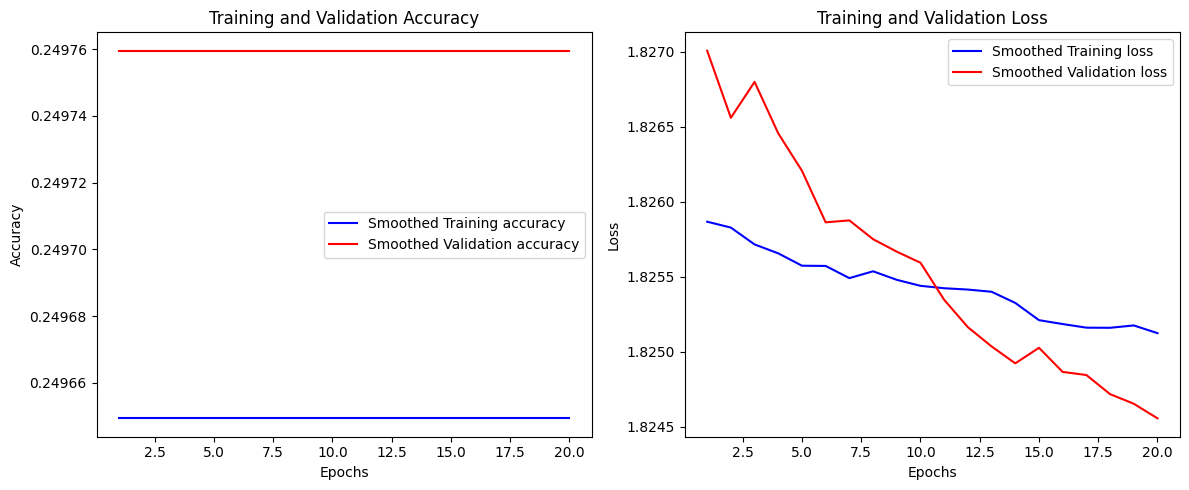

In [ ]:
import matplotlib.pyplot as plt

def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

print(acc)
print(val_acc)
print(loss)
print(val_loss)

smooth_acc = smooth_curve(acc)
smooth_val_acc = smooth_curve(val_acc)
smooth_loss = smooth_curve(loss)
smooth_val_loss = smooth_curve(val_loss)

epochs = range(1, len(acc) + 1)

# Plot training & validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, smooth_acc, 'b', label='Smoothed Training accuracy')
plt.plot(epochs, smooth_val_acc, 'r', label='Smoothed Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, smooth_loss, 'b', label='Smoothed Training loss')
plt.plot(epochs, smooth_val_loss, 'r', label='Smoothed Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



In [ ]:
!pip install mtcnn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 15.5 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import numpy as np
from mtcnn import MTCNN

data_path = "/content/drive/Shareddrives/CMPE 258 - Deep Learning Project/Datasets/train_data"
INPUT_SIZE = (224, 224)
classes = ["surprise", "sad", "neutral", "happy", "fear", "disgust", "angry"]
detector = MTCNN()

face_images = []
actual_labels = []

for emotion_folder in os.listdir(data_path):
    emotion_path = os.path.join(data_path, emotion_folder)
    if os.path.isdir(emotion_path):
        counter = 0  # Initialize a counter for each folder
        for img_file in os.listdir(emotion_path):
            if counter < 5:  # Process only 5 images per folder
                img_path = os.path.join(emotion_path, img_file)
                image = cv2.imread(img_path)
                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                faces = detector.detect_faces(image_rgb)

                for face in faces:
                    x, y, width, height = face['box']
                    face_image = image_rgb[y:y+height, x:x+width]
                    resized_face = cv2.resize(face_image, INPUT_SIZE)
                    face_images.append(resized_face)
                    actual_labels.append(emotion_folder)  # Folder name as the actual label

                counter += 1  # Increment the counter
            else:
                break  # Move to the next folder

# Convert lists to numpy arrays
face_images = np.array(face_images)


1/1 [==============================] - 0s 17ms/step


In [ ]:
predictions = custom_model.predict(face_images)

# Convert predictions to labels
predicted_labels = [classes[np.argmax(pred)] for pred in predictions]


1/1 [==============================] - 0s 24ms/step


Accuracy: 12.00%
              precision    recall  f1-score   support

    surprise       0.00      0.00      0.00         2
         sad       0.00      0.00      0.00         3
     neutral       0.00      0.00      0.00         4
       happy       0.12      1.00      0.21         3
        fear       0.00      0.00      0.00         3
     disgust       0.00      0.00      0.00         5
       angry       0.00      0.00      0.00         5

    accuracy                           0.12        25
   macro avg       0.02      0.14      0.03        25
weighted avg       0.01      0.12      0.03        25



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


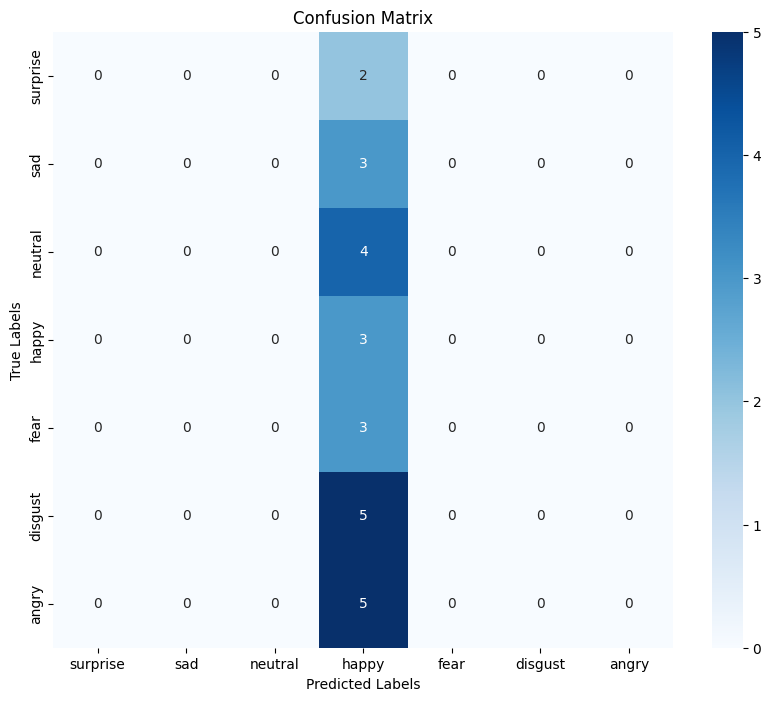

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Convert actual string labels to indices
actual_indices = [classes.index(label) for label in actual_labels]

# Convert predicted string labels to indices
predicted_indices = [classes.index(label) for label in predicted_labels]

# Calculate accuracy
accuracy = accuracy_score(actual_indices, predicted_indices)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Generate confusion matrix
cm = confusion_matrix(actual_indices, predicted_indices)

# Generate and print classification report
report = classification_report(actual_indices, predicted_indices, target_names=classes)
print(report)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
